# Statement

The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and you are asked to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data Preprocessing & Exploration

## Initialization

In [3]:
pip install scikit-learn --upgrade

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 23.2 MB 133 kB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Basic
import numpy as np
import pandas as pd
from scipy import math
import warnings
warnings.filterwarnings("ignore")

# Visualization
import seaborn as sns

# Metrics
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Modelling
import sklearn.linear_model
import sklearn.metrics
import sklearn.neighbors
import sklearn.preprocessing
from sklearn.neighbors import NearestNeighbors

# Preprocessing
from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data

Load data and conduct a basic check that it's free from obvious issues.

In [5]:
df = pd.read_csv('/datasets/insurance_us.csv')

We rename the colums to make the code look more consistent with its style.

In [6]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

## df.sample(10)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [8]:
# we may want to fix the age type (from float to int) though this is not critical

# write your conversion here if you choose:
df['age'] = df['age'].astype('int32')

In [9]:
# check to see that the conversion was successful
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null int32
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


In [10]:
# now have a look at the data's descriptive statistics. 
# Does everything look okay?

In [11]:
df.describe()

,gender,age,income,family_members,insurance_benefits
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,0.499000,30.952800,39916.360000,1.194200,0.148000
std,0.500049,8.440807,9900.083569,1.091387,0.463183
min,0.000000,18.000000,5300.000000,0.000000,0.000000
25%,0.000000,24.000000,33300.000000,0.000000,0.000000
50%,0.000000,30.000000,40200.000000,1.000000,0.000000
75%,1.000000,37.000000,46600.000000,2.000000,0.000000
max,1.000000,65.000000,79000.000000,6.000000,5.000000


Everything looks fine. The values are logical and there are no extreme ones.

We have 5,000 inspections
- Gender: we have to values, 0 and 1
- Age: rage between 18 and 65, which is logical, the mean is almost equal to the meadian, so the distribution of ages should be   quite simetric
- Income: ranges between 5,300 and 79,000. that also logical. and also mean and median are very close.
- Family members: ranges between 0 and 6. logical
- Insurance benefits: ranges between 0 and 5, where the mean in 0.148

In [12]:
# Looking for missing values
df.isna().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

There are no missing values

In [13]:
# Checking for duplications
df.duplicated().sum()

153

In [14]:
df.loc[df.duplicated()].sort_values('age')

,gender,age,income,family_members,insurance_benefits
2429,1,18,39800.0,2,0
2512,1,19,43200.0,1,0
2269,1,19,43200.0,1,0
4129,1,19,35600.0,2,0
2853,0,19,51700.0,0,0
...,...,...,...,...,...
1485,1,41,32700.0,0,0
3365,1,41,47100.0,1,0
3923,1,41,48900.0,0,0
1091,1,41,34000.0,1,0


There are 153 customers' inspections with the same values. Since we don't have any customer identity record, there is no issue having customers with the same features 

## EDA

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

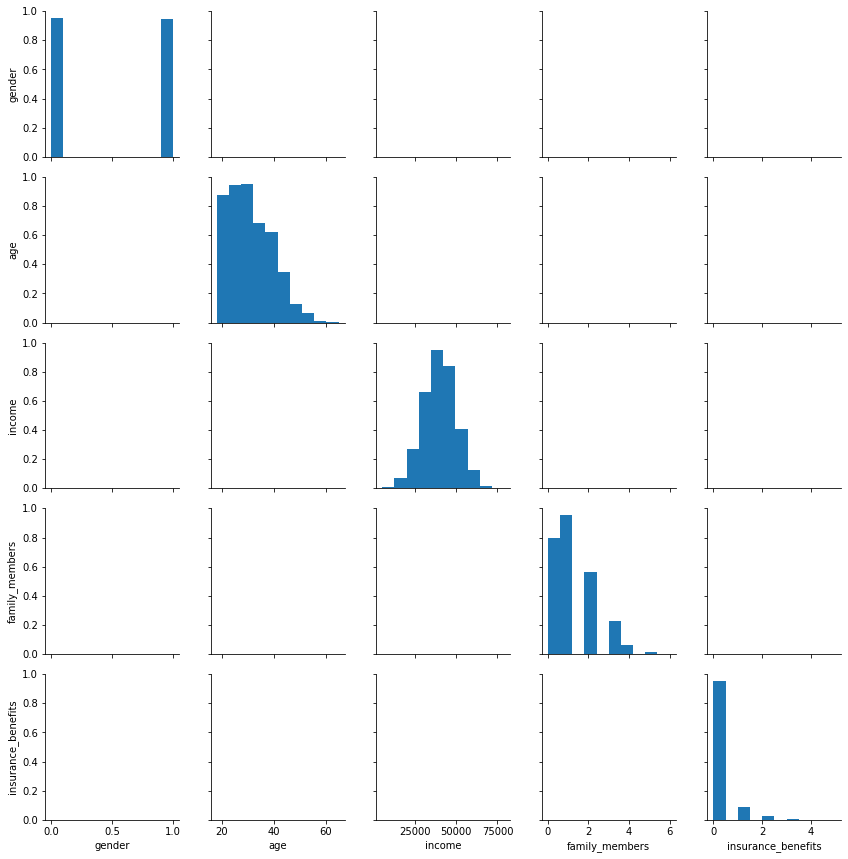

In [15]:
g = sns.pairplot(df, kind='hist')
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

You may want to review the following lessons (chapter -> lesson)
- Distance Between Vectors -> Euclidean Distance
- Distance Between Vectors -> Manhattan Distance

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

You can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use your own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [16]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [17]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """
    
    nbrs = NearestNeighbors(metric=metric) 
    nbrs.fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

**Scaling the data.**

In [18]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [19]:
df_scaled.sample(5)

,gender,age,income,family_members,insurance_benefits
3477,1.0,0.292308,0.581013,0.333333,0
3098,0.0,0.446154,0.469620,0.166667,0
2052,1.0,0.753846,0.500000,0.000000,2
456,1.0,0.492308,0.625316,0.166667,0
3721,0.0,0.569231,0.550633,0.500000,0


Now, let's get similar records for a given one for every combination

In [20]:
# Defining a functions that will get similar records for given n and k in four cmbinations
def four_combinations_knn(n,k):
# 1. Distance Metric: Euclidean + the data is not scaled
    print('Distance Metric: Euclidean')
    print('1. The data is not scaled')
    print(get_knn(df, n, k, 'euclidean'))
    print('')
# 2. Distance Metric: Euclidean + the data is scaled with the MaxAbsScaler scaler
    print('2. The data is scaled')
    print(get_knn(df_scaled, n, k, 'euclidean')) 
    print('')
    
# 3. Distance Metric: Manhattan + the data is not scaled
    print('Distance Metric: Manhattan')
    print('1. The data is not scaled')
    print(get_knn(df, n, k, 'manhattan')) 
    print('')
# 4. Distance Metric: Manhattan + the data is scaled with the MaxAbsScaler scaler
    print('2. The data is scaled')
    print(get_knn(df_scaled, n, k, 'manhattan')) 


In [21]:
# Testing n=22, k=5
n=22
k=5
four_combinations_knn(n,k)

Distance Metric: Euclidean
1. The data is not scaled
      gender  age   income  family_members  insurance_benefits  distance
22         0   41  26600.0               0                   0  0.000000
2181       0   40  26600.0               2                   0  2.236068
1776       1   37  26600.0               1                   0  4.242641
1063       0   46  26600.0               1                   1  5.099020
1267       1   33  26600.0               2                   0  8.306624

2. The data is scaled
      gender       age    income  family_members  insurance_benefits  distance
22       0.0  0.630769  0.336709             0.0                   0  0.000000
2873     0.0  0.630769  0.326582             0.0                   0  0.010127
435      0.0  0.646154  0.354430             0.0                   1  0.023468
894      0.0  0.615385  0.355696             0.0                   0  0.024438
2148     0.0  0.630769  0.310127             0.0                   0  0.026582

Distance Me

In [22]:
# Testing n=2920, k=3
n=2920
k=3
four_combinations_knn(n,3)

Distance Metric: Euclidean
1. The data is not scaled
      gender  age   income  family_members  insurance_benefits  distance
2920       0   35  56400.0               3                   0  0.000000
4119       0   35  56400.0               1                   0  2.000000
3327       1   39  56400.0               2                   0  4.242641

2. The data is scaled
      gender       age    income  family_members  insurance_benefits  distance
2920     0.0  0.538462  0.713924             0.5                   0  0.000000
915      0.0  0.553846  0.732911             0.5                   0  0.024438
4166     0.0  0.523077  0.688608             0.5                   0  0.029624

Distance Metric: Manhattan
1. The data is not scaled
      gender  age   income  family_members  insurance_benefits  distance
2920       0   35  56400.0               3                   0       0.0
4119       0   35  56400.0               1                   0       2.0
3327       1   39  56400.0               2 

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Yes, the results obtained by the scaled data are different from those obtained by the not scaled data.

When the data is not scaled the kNN algorithm, which gives same weight to all features, is heavily influenced by the big numbers features, like income in our case. when calculating distances between points the income have the highest weight. 

It appears by the fact that all the kneighbors found have the same income, but not the same gender, age or family members. meaning that the algorithm prefered the income feature when looking for the closest inspections.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

The results provided using the Manhatten distance metric are the same as those provided using the Euclidean distance metric, regardless of the scaling.
Both metrics returned the same indices, although the order is sometimes different, when the results are very close, because of the different methods. 

# Task 2. Is Customer Likely to Receive Insurance Benefit?

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [23]:
# calculate the target
# Converting the target to binary value by replacing all values higher then 0 to 1

df['insurance_benefits_received'] = df['insurance_benefits']
df.loc[df['insurance_benefits'] > 0 , ['insurance_benefits_received']] = 1

In [24]:
# check for the class imbalance with value_counts()

df['insurance_benefits_received'].value_counts()/df['insurance_benefits_received'].count()

0    0.8872
1    0.1128
Name: insurance_benefits_received, dtype: float64

In [25]:
# Calculating the probability of paying any insurance benefit 
df['insurance_benefits_received'].sum() / len(df)

0.1128

In [26]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
# if you have an issue with the following line, restart the kernel and run the notebook again
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [27]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [28]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = rnd_model_predict(P, len(df), seed=42)
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

The probability: 0.00
F1: 0.00
Confusion Matrix
[[0.8872 0.    ]
 [0.1128 0.    ]]

The probability: 0.11
F1: 0.12
Confusion Matrix
[[0.7914 0.0958]
 [0.0994 0.0134]]

The probability: 0.50
F1: 0.20
Confusion Matrix
[[0.456  0.4312]
 [0.053  0.0598]]

The probability: 1.00
F1: 0.20
Confusion Matrix
[[0.     0.8872]
 [0.     0.1128]]



In [29]:
def customer_benefit_pred(features, target):
    # Split the data into train and test sets
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.3, random_state=12345)

    for k in range (1,11):
        print(f'K: {k}')
        knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=k)
        # Model train
        knn_model.fit(features_train, target_train)
        # Preict targets from test set
        y_pred = knn_model.predict(features_test)
        # Calculating F1
        F1_score = eval_classifier(target_test, y_pred)
    return F1_score

In [30]:
# Measure model quality with original data:
features = df.drop(['insurance_benefits','insurance_benefits_received'], axis=1)
target = df['insurance_benefits_received']

customer_benefit_pred(features, target)

K: 1
F1: 0.62
Confusion Matrix
[[0.87133333 0.02      ]
 [0.05133333 0.05733333]]
K: 2
F1: 0.41
Confusion Matrix
[[0.88733333 0.004     ]
 [0.08       0.02866667]]
K: 3
F1: 0.41
Confusion Matrix
[[0.88       0.01133333]
 [0.07733333 0.03133333]]
K: 4
F1: 0.28
Confusion Matrix
[[0.88866667 0.00266667]
 [0.09066667 0.018     ]]
K: 5
F1: 0.27
Confusion Matrix
[[0.88533333 0.006     ]
 [0.09066667 0.018     ]]
K: 6
F1: 0.11
Confusion Matrix
[[0.89       0.00133333]
 [0.102      0.00666667]]
K: 7
F1: 0.11
Confusion Matrix
[[0.88866667 0.00266667]
 [0.102      0.00666667]]
K: 8
F1: 0.07
Confusion Matrix
[[0.89133333 0.        ]
 [0.10466667 0.004     ]]
K: 9
F1: 0.08
Confusion Matrix
[[0.89133333 0.        ]
 [0.104      0.00466667]]
K: 10
F1: 0.00
Confusion Matrix
[[0.89133333 0.        ]
 [0.10866667 0.        ]]


In [31]:
# Measure model quality with scaled data:

# calculate the target
# Converting the target to binary value by replacing all values higher then 0 to 1
df_scaled['insurance_benefits_received'] = df_scaled['insurance_benefits']
df_scaled.loc[df_scaled['insurance_benefits'] > 0 , ['insurance_benefits_received']] = 1

features = df_scaled.drop(['insurance_benefits','insurance_benefits_received'], axis=1)
target = df_scaled['insurance_benefits_received']

customer_benefit_pred(features, target)

K: 1
F1: 0.97
Confusion Matrix
[[0.88866667 0.00266667]
 [0.00466667 0.104     ]]
K: 2
F1: 0.93
Confusion Matrix
[[8.90666667e-01 6.66666667e-04]
 [1.40000000e-02 9.46666667e-02]]
K: 3
F1: 0.95
Confusion Matrix
[[0.88933333 0.002     ]
 [0.00866667 0.1       ]]
K: 4
F1: 0.91
Confusion Matrix
[[0.88933333 0.002     ]
 [0.01666667 0.092     ]]
K: 5
F1: 0.92
Confusion Matrix
[[0.88666667 0.00466667]
 [0.01133333 0.09733333]]
K: 6
F1: 0.90
Confusion Matrix
[[0.89       0.00133333]
 [0.018      0.09066667]]
K: 7
F1: 0.92
Confusion Matrix
[[0.88733333 0.004     ]
 [0.01266667 0.096     ]]
K: 8
F1: 0.90
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01733333 0.09133333]]
K: 9
F1: 0.92
Confusion Matrix
[[0.88866667 0.00266667]
 [0.01466667 0.094     ]]
K: 10
F1: 0.88
Confusion Matrix
[[0.88866667 0.00266667]
 [0.02133333 0.08733333]]


**Conclusions**:

**"The F1 score can be interpreted as a harmonic mean of the precision and recall"*
- The dummy model's best F1 score was 0.2, in P value of 0.50 and higher.
- Our KNN-based classifier F1 score is much better then the dummy model.
- We can see that as k parameter is growing, F1 score decrease (from 0.62 for k=1 to 0, for k=10 in the original data testing). We see that the true positive rate is quite stable, but the true negative is decreasing
- With the scaled data, the resultsed F1 score is much better then for the original data. from 0.97 for k=1 to 0.88 for k=10. We can see also in this case, that the true positive rate stayed the same, but true negative rate decreased and false positive also decreased. We can understand that as k parameters is higher, more positive predictions are given (not necessarily true ones)

**The conclusion in this case may be that higher k is not necessarily good. it may lead to predicting according to non relevant and miss-leading neighbors**

# Task 3. Regression (with Linear Regression)

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [32]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        
        self.weights = np.linalg.inv(X2.T.dot(X2)).dot(X2.T).dot(y)
        
        self.w0 = self.weights[0]
        self.weights = self.weights[1:]

    def predict(self, X):
        
        # adding the unities
        X2 = X
        y_pred = X2.dot(self.weights) + self.w0
        
        return y_pred

In [33]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [34]:
# Train and test the model with original data

X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 3.57495491e-02  1.64272726e-02 -2.60743659e-07 -1.16902127e-02]
RMSE: 0.34
R2: 0.66


In [35]:
# Train and test the model with scaled data

X = df_scaled[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df_scaled['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

[ 2.32372069  0.01642727 -0.02059875 -0.07014128]
RMSE: 0.34
R2: 0.66


**Conclusions**

There is no difference in RMSE (or R2) between the original and scaled data

# Task 4. Obfuscating Data

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Multiplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [36]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [37]:
X = df_pn.to_numpy()

In [38]:
df_pn.head()

,gender,age,income,family_members
0,1,41,49600.0,1
1,0,46,38000.0,1
2,0,29,21000.0,0
3,0,21,41700.0,2
4,1,28,26100.0,0


Generating a random matrix $P$.

In [39]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

In [40]:
np.linalg.inv(P)

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

Yes, it is invertible

In [41]:
# Obfuscating personal info
obs_df = X.dot(P)

Can you guess the customers' ages or income after the transformation?

In [42]:
# Age
obs_df[0:10,[1]]

array([[22380.40467609],
       [17160.36702982],
       [ 9486.397744  ],
       [18803.22720286],
       [11782.82928336],
       [18509.8596165 ],
       [17920.45540783],
       [17413.01768645],
       [22420.56515812],
       [23317.43454451]])

In [43]:
# Income
obs_df[0:10,[2]]

array([[18424.09074184],
       [14125.78076133],
       [ 7808.83156024],
       [15479.14837264],
       [ 9699.99894205],
       [15237.19342704],
       [14752.11143673],
       [14334.46448264],
       [18457.36484575],
       [19195.91633541]])

No, its impossible to guess the values of age or income out of the transformed data

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

In [44]:
# Explaining the steps:
# obs_df = X.dot(P)
# obs_df.dot(np.linalg.inv(P)) = (X.dot(P)).dot(np.linalg.inv(P))
# we can remove  P(P)−1  of the equation
# obs_df.dot(np.linalg.inv(P)) = X
# X = obs_df.dot(np.linalg.inv(P))

X_recovered = obs_df.dot(np.linalg.inv(P))
with np.printoptions(suppress=True): 
    print(X_recovered[0:10])

[[    1.    41. 49600.     1.]
 [    0.    46. 38000.     1.]
 [   -0.    29. 21000.    -0.]
 [   -0.    21. 41700.     2.]
 [    1.    28. 26100.    -0.]
 [    1.    43. 41000.     2.]
 [    1.    39. 39700.     2.]
 [    1.    25. 38600.     4.]
 [    1.    36. 49700.     1.]
 [    1.    32. 51700.     1.]]


Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

In [45]:
# Original data

for i in[5,100,1000,1500]:
    with np.printoptions(suppress=True): 
        print(X[i])

[    1.    43. 41000.     2.]
[    0.    19. 37300.     1.]
[    1.    41. 42600.     1.]
[    1.    25. 35600.     2.]


In [46]:
# Transformed data

for i in[5,100,1000,1500]:
    print(obs_df[i])

[ 5258.77025195 18509.8596165  15237.19342704 38032.31715339]
[ 4781.07173353 16818.7550698  13845.67137241 34583.49654457]
[ 5462.91984441 19227.70311082 15828.50457221 39513.34176822]
[ 4565.26144324 16060.21434954 13221.18358155 33013.63705611]


In [47]:
# Recovered data

for i in[5,100,1000,1500]:
    with np.printoptions(suppress=True): 
        print(X_recovered[i,:])

[    1.    43. 41000.     2.]
[    0.    19. 37300.     1.]
[    1.    41. 42600.     1.]
[    1.    25. 35600.     2.]


You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

Answer:

I saw that there are some difference between the original and the recovered values. The reason is that some decimals were lost
in the way of multiplication and divisionץ
I had to use the printoptions(suppress=True) since the notebook started to represent all the values in scientific mode.

## Proof That Data Obfuscation Can Work with LR

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

$w_P$ is $w$ multiplied by the inversion matrix of $P$ matrix

The predicted values will be the same with $w_P$

The quality of linear regression measured with RMSE will have the same values.

**Analytical proof**

Data is obfuscated and there is $X \times P$ instead of just $X$ now

$w_P = [(XP)^T XP]^{-1} (XP)^T y$

Applying Matrix Property "Reversivity of the transpose of a product of matrices": $(AB)^T = B^TA^T$


$w_P = [(P^TX^T)XP]^{-1}(P^TX^T)y$

Applying Matrix Property "Multiplicative identity property": $(AB)^{-1} = B^{-1}A^{-1}$


$w_P = (XP)^{-1}(P^TX^T)^{-1}(P^TX^T)y$

And again:  

$w_P = (P)^{-1}(X)^{-1}(X^T)^{-1}(P^T)^{-1}(P^TX^T)y$  

We know $(P^T)^{-1}P^{T} = I$. $I$ refers to the identity matrix and the product of any square matrix and the identity matrix is always the original matrix. Hence, we can remove $(P^T)^{-1}P^{T}$ of the equation 


$w_P = [P^{-1}X^{-1}(X^T)^{-1}X^T]y$

Using Matrix Property "Multiplicative identity property", $X^{-1}(X^{T})^{-1}$ can be also expressed by $(X^{T}X)^{-1}$


$w_P = [P^{-1}(X^TX)^{-1}X^T]y$

We know that $w = (X^T X)^{-1} X^T y$
Hence, we can replace this part of the equation with w

$w_P = P^{-1}w$

wp is w multiplied by the inversed P matrix

This formula can be used to calculate predicted values
$\hat{y} = X_{val}w$

And this is how we calculate predicted values 
$\hat{y_2} = (XP)(P^{-1}w)$

We can remove $P(P^{-1})$  of the equation
and we get $\hat{y_2} = X_{val}w$

Conclusion: The predicted y from the obfuscated data is the same as the one from the original data

## Test Linear Regression With Data Obfuscation

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

In [48]:
# Creating square random numbers matrix

rng = np.random.default_rng(seed=123)
P = rng.random(size=(X.shape[1], X.shape[1]))

In [49]:
# Checking P is invertible
np.linalg.inv(P)

array([[ 2.19450806, -0.03188876,  0.05217293, -0.64857954],
       [-2.32630105, -0.66611646,  1.8073291 ,  0.27050733],
       [ 3.47767967,  2.46318223, -2.15521329, -1.2612122 ],
       [-6.1753682 , -2.63150913,  1.85521818,  3.82879052]])

In [50]:
class LinearRegression:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)
        y = train_target
        w = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
        self.w = w[1:]
        self.w0 = w[0]

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0

In [51]:
# Original data

features = df[['age', 'gender', 'income', 'family_members']].to_numpy()
target = df['insurance_benefits'].to_numpy()

LR1 = LinearRegression()
LR1.fit(features, target)
predictions_lr1 = LR1.predict(features)
print(predictions_lr1)

[ 0.51172715  0.68431581  0.09373365 ... -0.25697046 -0.19099161
  0.04904991]


In [52]:
print('R2: ', r2_score(target, predictions_lr1))
mse = mean_squared_error(target, predictions_lr1)
print('RMSE: ',math.sqrt(mse))

R2:  0.42494550286668
RMSE:  0.3512077581960692


In [53]:
# Obfuscated data

# Creating obfuscated data:
#X2 = df.dot(P)
features2 = features.dot(P)

LR2 = LinearRegression()
LR2.fit(features2, target)
predictions_lr2 = LR2.predict(features2)
print(predictions_lr2)

[ 0.51172736  0.68431566  0.09373344 ... -0.2569706  -0.19099138
  0.0490501 ]


In [54]:
print('R2: ',r2_score(target, predictions_lr2))
mse = mean_squared_error(target, predictions_lr2)
print('RMSE: ',math.sqrt(mse))

R2:  0.42494550286646104
RMSE:  0.35120775819613603


# Conclusions

There is no difference between the original and obfuscated data in the predicted values and the RMSE & $R^2$ metric values.

**Summary:**

We received data of 5,000 customer of inssurance company. our goal was to predict which of the customers is prone to claim some inssurance benefits according to personal characteristics and his claims history.

- We found that for knn scailed data brought more precise results of k neighbors 
- We found that there was no different in k neighbors between the Euclidean Distance and Manhattan Distance methods
- Our KNN-based classifier F1 score is much better then the dummy model.
 - We saw that as k parameter was growing, F1 score decreased  
 - With the scaled data, the resultsed F1 score is much better then for the original data.
- Linear regression - we found no difference in RMSE (or R2) between original and scaled data 
- We found that obfuscated data can protect sensetive data efficiently using random matrix, and this does not affect linear regression in terms of predicted values.